In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import model
import time
from datetime import datetime
from datetime import timedelta
sns.set()

%matplotlib notebook

In [2]:
df = pd.read_csv('../dataset/predict-set-20190527-0531.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Timestamp,Close,High,Low,Open,Volume
0,1558915200,8653.011422,8660.000000,8607.303062,8616.502752,20803.498272
1,1558915500,8689.545605,8729.091604,8653.815050,8653.815050,122780.290759
2,1558915800,8682.085232,8698.578593,8658.146320,8682.595359,48788.811247
3,1558916100,8733.177325,8733.177325,8700.000000,8700.000000,36294.412783
4,1558916400,8811.826574,8815.225937,8734.000000,8734.000000,164608.486049


In [3]:
print(df.iloc[:, 3].values)

[8607.30306214 8653.81505023 8658.14631965 ... 8276.7639935  8289.24261714
 8285.95789154]


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4].values.reshape((-1,1)))
close_normalize = minmax.transform(df.iloc[:, 4].values.reshape((-1,1))).reshape((-1))

In [5]:
close_normalize.shape

(1300,)

In [6]:
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

In [7]:
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape

Instructions for updating:
Colocations handled automatically by placer.
epoch: 10 loss: 0.12769087 time: 0.002481698989868164
epoch: 20 loss: 0.025947224 time: 0.0023632049560546875
epoch: 30 loss: 0.023778858 time: 0.002094268798828125
epoch: 40 loss: 0.020975903 time: 0.008569955825805664
epoch: 50 loss: 0.017120704 time: 0.002570629119873047
epoch: 60 loss: 0.012332812 time: 0.002200603485107422
epoch: 70 loss: 0.027426247 time: 0.0022363662719726562
epoch: 80 loss: 0.14949536 time: 0.003182649612426758
epoch: 90 loss: 0.16773792 time: 0.0031092166900634766
epoch: 100 loss: 0.047462672 time: 0.0022521018981933594


(1300, 32)

In [8]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

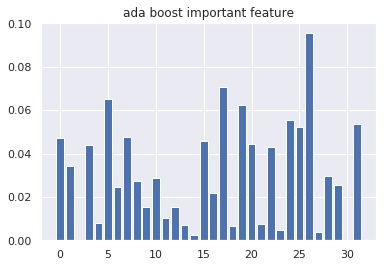

In [10]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

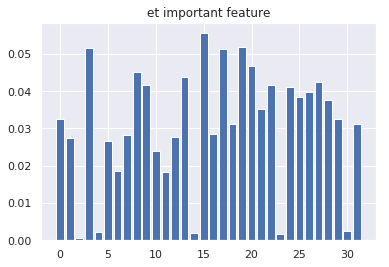

In [11]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

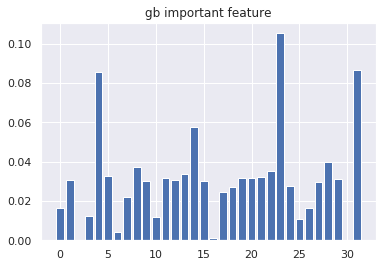

In [12]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

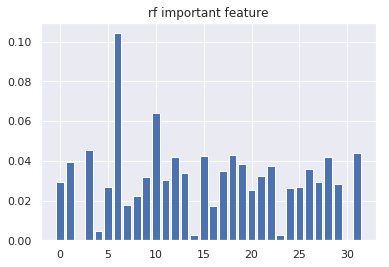

In [13]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [14]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

In [15]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

In [16]:
print(ada_actual[0:5])
print(et_actual[0:5])
print(stack_predict[0:5])

[0.52661307 0.53886997 0.56772763 0.60301984 0.62995112]
[0.52661307 0.56928082 0.60219198 0.62209311 0.62748179]
[[0.52661307 0.52661307 0.52661307 0.52661307 0.52661307 0.52661307]
 [0.53886997 0.5546812  0.56928082 0.5610596  0.55412702 0.56928082]
 [0.56772763 0.58927416 0.60219198 0.58811275 0.5895704  0.60219198]
 [0.60301984 0.60355569 0.62209311 0.60714821 0.6028225  0.62209472]
 [0.62995112 0.62764553 0.62748179 0.62577798 0.62722205 0.66097476]]


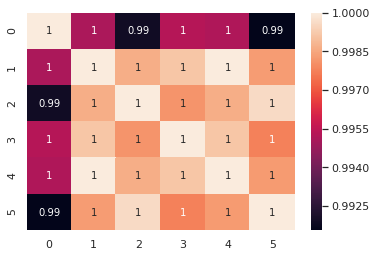

In [17]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

# Wow, I do not expect this heatmap. Totally a heat!

In [18]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [19]:
xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [20]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

<IPython.core.display.Javascript object>


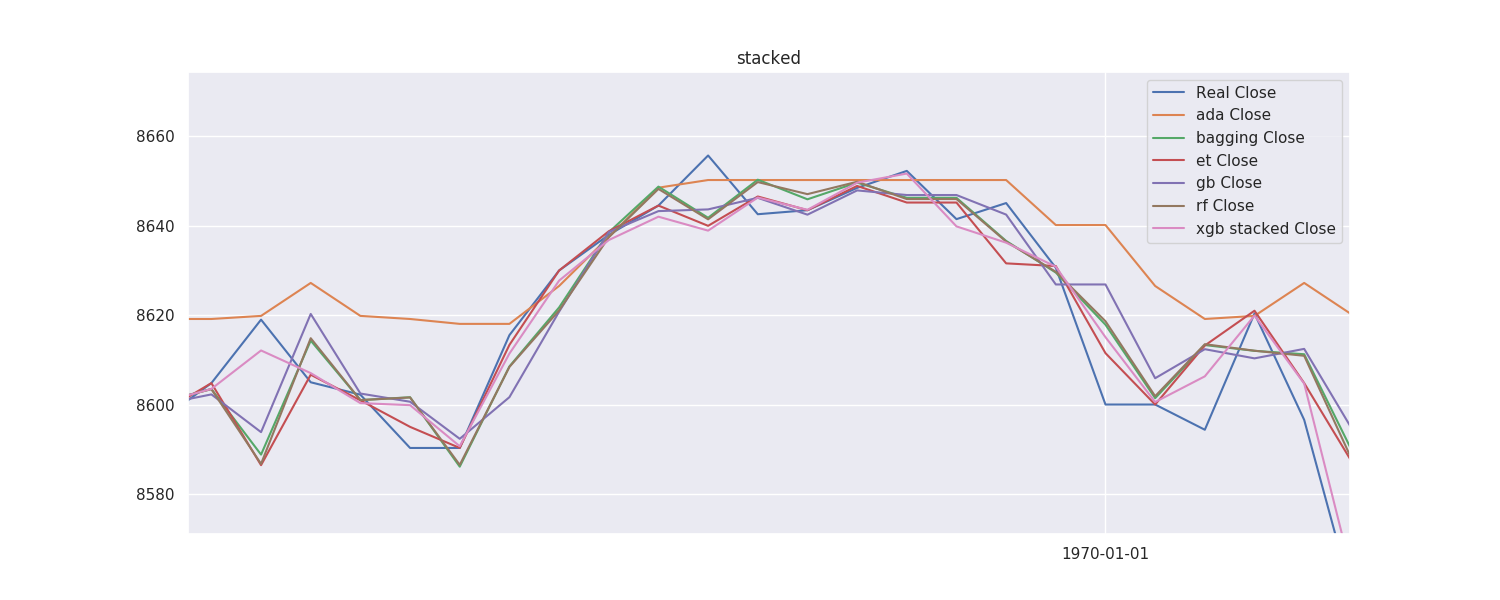

In [28]:
%matplotlib notebook
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

In [22]:
# 基于上次的预测结果，按照history窗口，又堆叠起来，再做一次预测 ?

ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()
def predict(count, history = 5):
    for i in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1,1)))
        ada_pred=ada.predict(thought_vector)
        bagging_pred=bagging.predict(thought_vector)
        et_pred=et.predict(thought_vector)
        gb_pred=gb.predict(thought_vector)
        rf_pred=rf.predict(thought_vector)
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])
        ada_actual = np.hstack([xgb_list[-history],ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history],bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history],et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history],gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history],rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1]+timedelta(days=1))

In [23]:
predict(30, history = 5)

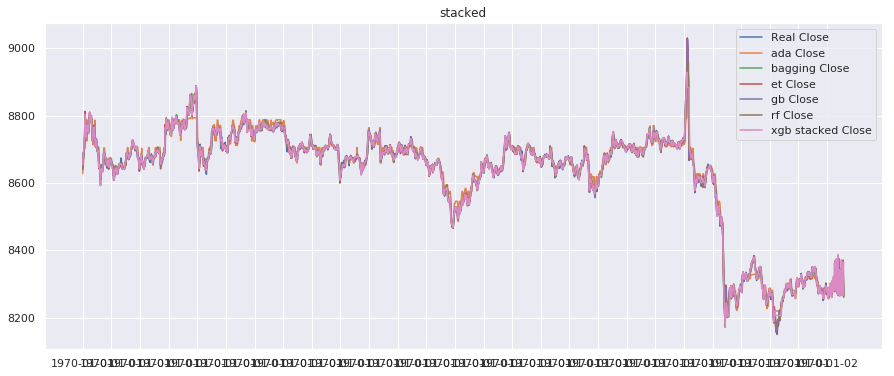

In [24]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

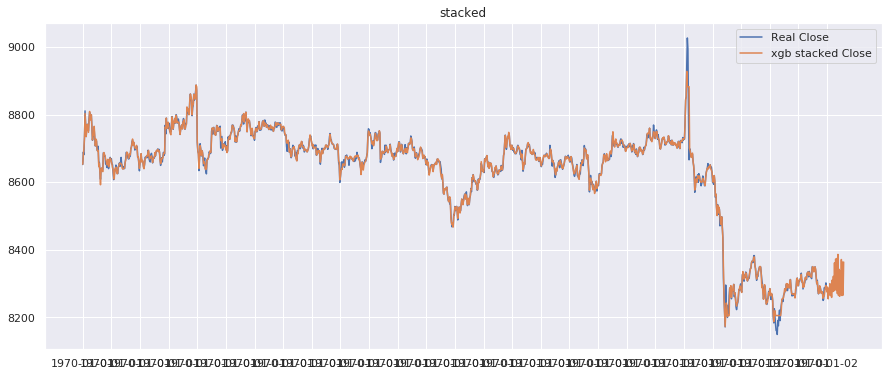

In [25]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')

plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

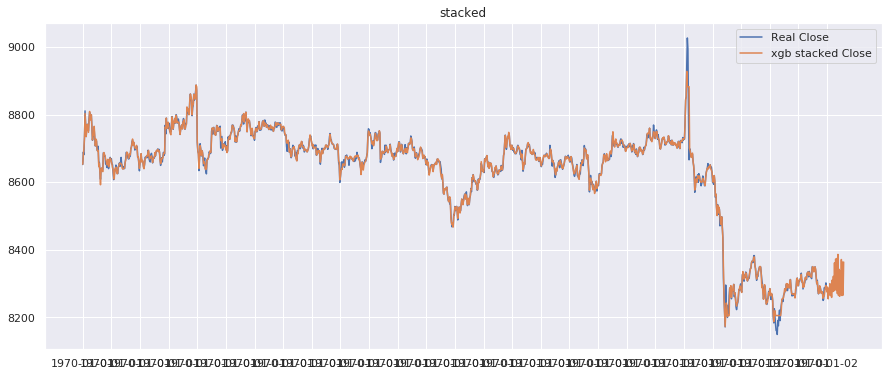

In [26]:

plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

In [27]:
a = np.diff(df.Close) > 0
b = np.diff(xgb_pred) > 0

#比较相同值的个数
print(sum(a == b), '/', a.shape[0], '=', sum(a == b)/a.shape[0])

1066 / 1299 = 0.8206312548113934
